In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

In [2]:
class CliffWalkingEnv:
    """A configurable Cliff Walking Environment."""
    def __init__(self, cliff_positions):
        self.height = 4
        self.width = 12
        self.start_state = (3, 0)
        self.goal_state = (3, 11)
        self.cliff = cliff_positions
        self.actions = ['up', 'down', 'left', 'right']
        self.action_map = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
        self.state = self.start_state

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        move = self.action_map[self.actions[action]]
        next_state = (self.state[0] + move[0], self.state[1] + move[1])
        next_state = (max(0, min(self.height - 1, next_state[0])), max(0, min(self.width - 1, next_state[1])))
        self.state = next_state
        reward = -1
        done = False
        if self.state in self.cliff:
            reward = -100
            self.state = self.start_state
        elif self.state == self.goal_state:
            done = True
        return self.state, reward, done

In [3]:
class Agent:
    """A base class for SARSA and Q-Learning agents."""
    def __init__(self, env, alpha=0.5, gamma=1.0, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((env.height, env.width, len(env.actions)))

    def choose_action(self, state, is_learning=True):
        """Chooses an action. If not learning, it's purely greedy."""
        if is_learning and np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(len(self.env.actions))
        else:
            q_values = self.q_table[state]
            max_q = np.max(q_values)
            return np.random.choice(np.where(q_values == max_q)[0])

In [4]:
class SarsaAgent(Agent):
    """On-policy SARSA agent."""
    def update(self, state, action, reward, next_state, next_action):
        current_q = self.q_table[state][action]
        next_q = self.q_table[next_state][next_action]
        td_target = reward + self.gamma * next_q
        self.q_table[state][action] += self.alpha * (td_target - current_q)

In [5]:
class QLearningAgent(Agent):
    """Off-policy Q-learning agent."""
    def update(self, state, action, reward, next_state):
        current_q = self.q_table[state][action]
        max_next_q = np.max(self.q_table[next_state])
        td_target = reward + self.gamma * max_next_q
        self.q_table[state][action] += self.alpha * (td_target - current_q)

In [6]:
def run_experiment(agent, env, num_episodes):
    rewards_per_episode = []
    for _ in range(num_episodes):
        state = env.reset()
        action = agent.choose_action(state)
        done = False
        total_reward = 0
        while not done:
            next_state, reward, done = env.step(action)
            total_reward += reward
            if isinstance(agent, SarsaAgent):
                next_action = agent.choose_action(next_state)
                agent.update(state, action, reward, next_state, next_action)
                action = next_action
            else: # QLearningAgent
                agent.update(state, action, reward, next_state)
                action = agent.choose_action(next_state)
            state = next_state
        rewards_per_episode.append(total_reward)
    return rewards_per_episode

def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

In [7]:
# --- NEW FUNCTION FOR VISUALIZATION ---
def run_one_episode(agent, env):
    """Runs one episode with a trained agent and returns the path taken."""
    path = [env.start_state]
    state = env.reset()
    done = False
    while not done:
        # Use the greedy policy (is_learning=False)
        action = agent.choose_action(state, is_learning=False)
        state, _, done = env.step(action)
        path.append(state)
    return path

In [8]:
# --- NEW FUNCTION TO DRAW THE PATH ---
def visualize_path(ax, env, path, title):
    """Draws the grid, cliff, and the agent's path on a given subplot ax."""
    ax.set_xticks(np.arange(-.5, env.width, 1), minor=True)
    ax.set_yticks(np.arange(-.5, env.height, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Color the grid cells
    for r in range(env.height):
        for c in range(env.width):
            cell = (r, c)
            if cell == env.start_state:
                ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='lightblue'))
                ax.text(c, r, 'S', va='center', ha='center')
            elif cell == env.goal_state:
                ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='lightgreen'))
                ax.text(c, r, 'G', va='center', ha='center')
            elif cell in env.cliff:
                ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='gray'))

    # Plot the path
    path_ys, path_xs = zip(*path)
    ax.plot(path_xs, path_ys, marker='o', linestyle='-', color='red', markersize=4)
    ax.set_title(title, fontsize=14)
    ax.set_aspect('equal')


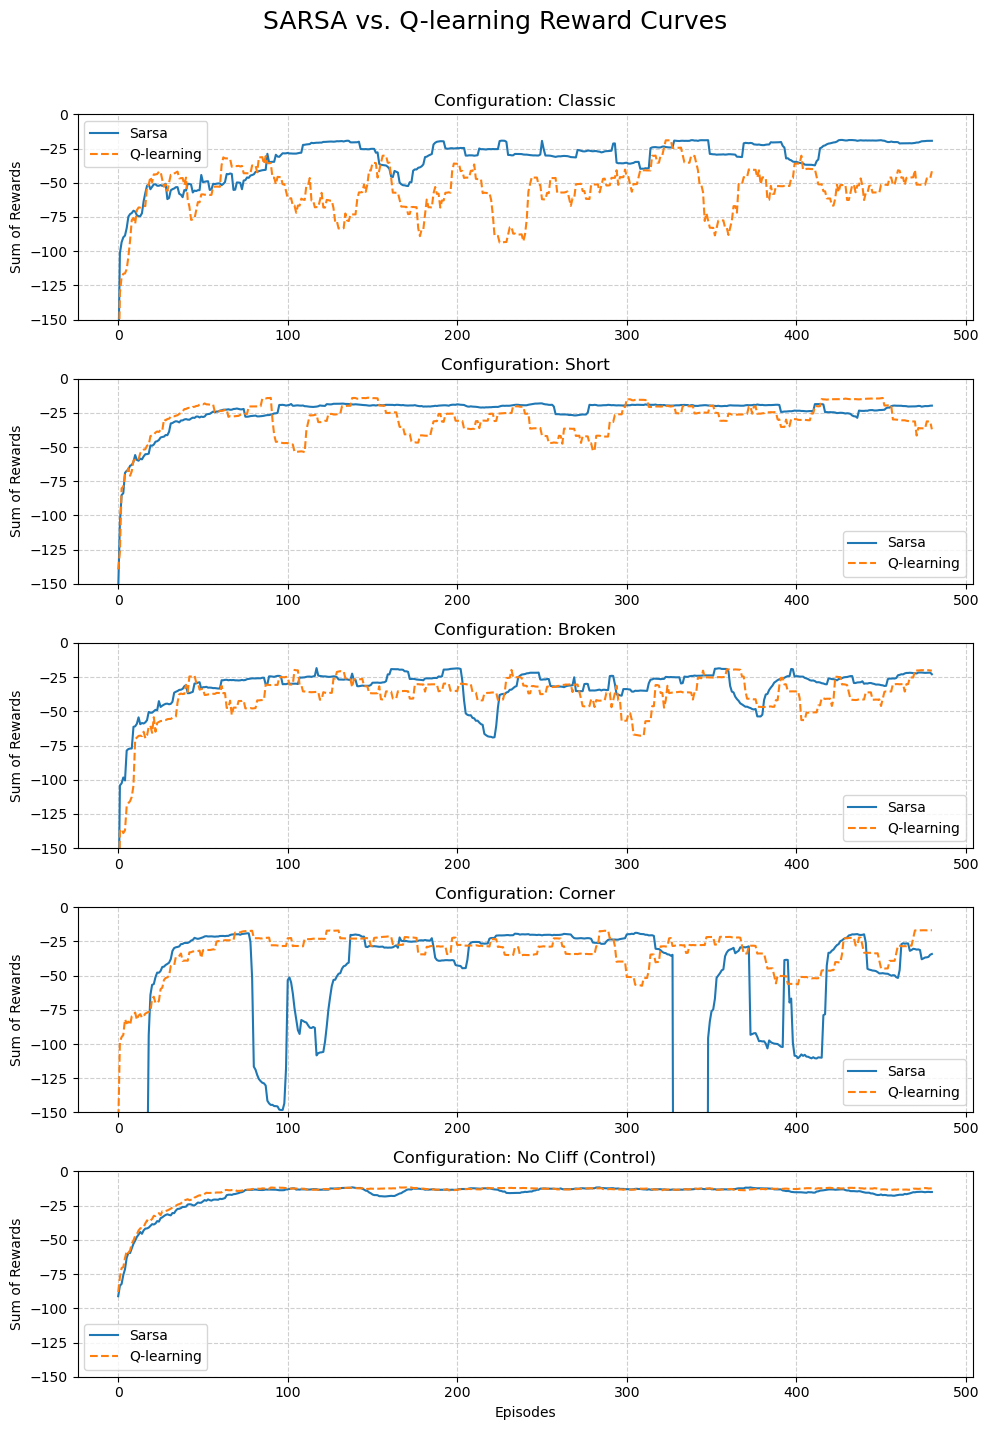


Training agents for path visualization on the 'Classic' configuration...


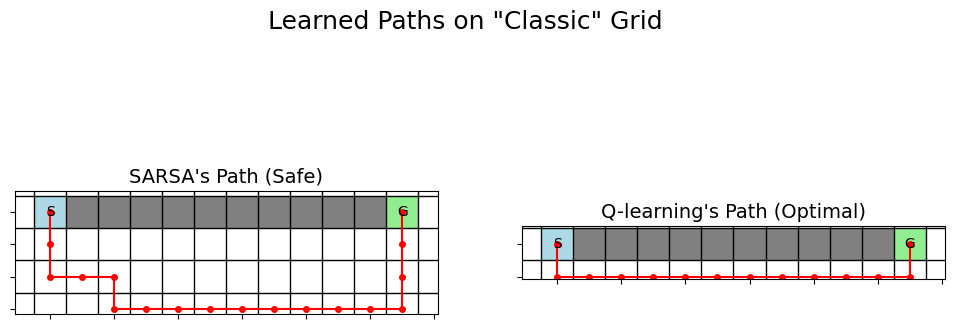

In [9]:
if __name__ == "__main__":
    num_episodes = 500
    cliff_configs = {
        "Classic": [(3, i) for i in range(1, 11)],
        "Short": [(3, i) for i in range(4, 8)],
        "Broken": [(3, 1), (3, 2), (3, 5), (3, 6), (3, 9), (3, 10)],
        "Corner": [(2, i) for i in range(8, 11)] + [(3, 8)],
        "No Cliff (Control)": []
    }
    
    # --- Part 1: Plotting Reward Curves (same as before) ---
    fig_rewards, axes_rewards = plt.subplots(nrows=len(cliff_configs), ncols=1, figsize=(10, 15), sharey=True)
    fig_rewards.suptitle('SARSA vs. Q-learning Reward Curves', fontsize=18)

    for i, (config_name, positions) in enumerate(cliff_configs.items()):
        ax = axes_rewards[i]
        env = CliffWalkingEnv(cliff_positions=positions)
        # Run experiments and plot...
        sarsa_agent = SarsaAgent(env)
        sarsa_rewards = run_experiment(sarsa_agent, env, num_episodes)
        qlearning_agent = QLearningAgent(env)
        qlearning_rewards = run_experiment(qlearning_agent, env, num_episodes)
        ax.plot(moving_average(sarsa_rewards), label='Sarsa', color='#1f77b4')
        ax.plot(moving_average(qlearning_rewards), label='Q-learning', color='#ff7f0e', linestyle='--')
        ax.set_title(f'Configuration: {config_name}')
        ax.set_ylabel('Sum of Rewards')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend()
        ax.set_ylim(-150, 0)
    axes_rewards[-1].set_xlabel('Episodes')
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # --- Part 2: Visualizing the Learned Path for the "Classic" Configuration ---
    print("\nTraining agents for path visualization on the 'Classic' configuration...")
    classic_env = CliffWalkingEnv(cliff_positions=cliff_configs["Classic"])
    
    # Train SARSA agent
    sarsa_agent_vis = SarsaAgent(classic_env)
    run_experiment(sarsa_agent_vis, classic_env, num_episodes)
    sarsa_path = run_one_episode(sarsa_agent_vis, classic_env)

    # Train Q-learning agent
    qlearning_agent_vis = QLearningAgent(classic_env)
    run_experiment(qlearning_agent_vis, classic_env, num_episodes)
    qlearning_path = run_one_episode(qlearning_agent_vis, classic_env)

    # Create the visualization plot
    fig_paths, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig_paths.suptitle('Learned Paths on "Classic" Grid', fontsize=18)
    
    visualize_path(ax1, classic_env, sarsa_path, "SARSA's Path (Safe)")
    visualize_path(ax2, classic_env, qlearning_path, "Q-learning's Path (Optimal)")
    
    plt.show()